# Topic Modelling(Clustering)


#### Latent Dirichlet allocation (LDA) is a generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. 

For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics.


#### LDA is an example of a topic model.


LSA-Latent Semantic Analysis   
matrix Factorization(SVD)

In [ ]:
#!pip install gensim 

# it has the package to do Topic modelling 

#### Gensim doesnot take input as Dataframe , but it takes each document with unique terms as a individual list

doc1-[(t1,1),(t3,1)....]  
doc2-[(t1,1),(t3,1),(t5,1)..]  
.
.
doc-n-[(t1,2),(t2,4)...]   

where tuple formed inside the list is(term,frequencyin the doc)  and each term is assigned a unique ID instead of the term in string


In [1]:
# importing the basic libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
import gensim


In [2]:
# reading the Modi Tweets csv
data=pd.read_csv('C:\\Users\\HII\\Desktop\\Text Mining\\10 Text Mining\\abcnews.csv').sample(100000)
data.head()

,publish_date,headline_text
191132,20050928,miners losses keep market flat
767505,20130303,former qantas director james strong dies
172404,20050628,federal govt to help austop workers
188434,20050915,brumby criticises opposition toll funds plan
1022868,20160506,childs death from meningitis maybe avoidable c...


In [3]:
data.shape

(100000, 2)



# Bag of word analysis

  We take text column as input and identify the individual words and their frequency of each unique word.
  From those individual words we will come to an idea what area the words are refering .
  
  

In [4]:
from wordcloud import WordCloud

## Word size /font size depends on the frequency of the word i.e higher freq is in bigger size

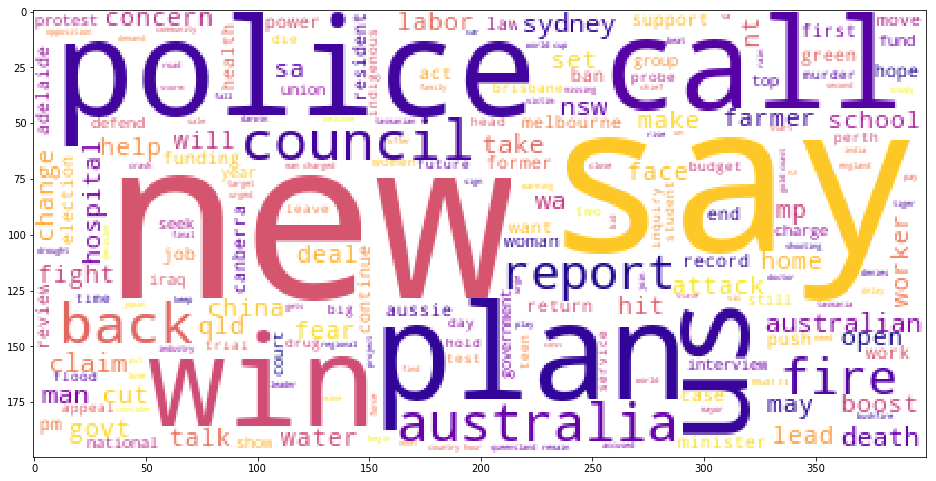

In [6]:

plt.figure(figsize=[16,14])
text=' '.join(data['headline_text'].values)
wc=WordCloud(background_color='white',colormap='plasma').generate(text)
plt.imshow(wc)


# Text Cleaning

In [42]:
docs=data.headline_text.fillna("").str.lower().str.replace('[^a-z ]','')

stopwords=nltk.corpus.stopwords.words('english')
stopwords.extend(["",'says','us','one','sa','new','man'])# to add custom stopword list to our original list ofn stopwords
stemmer=nltk.stem.PorterStemmer()
# Function to clean the each doc with stopwords and lemmitiation
def clean_doc(doc):
    words=doc.split(" ")
    words_clean=[stemmer.stem(w) for w in words if w not in stopwords]
    words_clean=[w for w in words_clean if w not in stopwords]
    return words_clean
docs_clean=docs.apply(clean_doc)
docs_clean.head()

191132                    [miner, loss, keep, market, flat]
767505         [former, qanta, director, jame, strong, die]
172404                  [feder, govt, help, austop, worker]
188434        [brumbi, criticis, opposit, toll, fund, plan]
1022868    [child, death, mening, mayb, avoid, coron, find]
Name: headline_text, dtype: object

In [43]:
# gensim converts the unique word dictionary 
dictionary=gensim.corpora.Dictionary(docs_clean)

In [44]:
# Getting the bag of words in each document 
docs_bow=[]
for i in docs_clean:
    bow=dictionary.doc2bow(i)
    docs_bow.append(bow)



# docs_bow has the input format required for gensim package to process it to do Topic classification/ modelling


In [45]:
lda_mod=gensim.models.LdaMulticore(docs_bow,
                               id2word=dictionary,
                                  num_topics=4,random_state=100,iterations=300)

In [36]:
                             
#%timeit gensim.models.LdaMulticore(docs_bow,id2word=dictionary,num_topics=4)

In [37]:
                               
#%timeit gensim.models.LdaModel(docs_bow,id2word=dictionary,num_topics=4)

## Document- Topic Relationship

In [38]:

lda_mod.get_document_topics(docs_bow[8])


[(0, 0.2494792), (1, 0.42999253), (2, 0.036915395), (3, 0.2836129)]

In [46]:
# unitagging - tagging each doc with highest probable topic
topics=[]
for i in docs_bow:
    df=pd.DataFrame(lda_mod.get_document_topics(i),columns=['topic','Probs'])
    topic=df.sort_values(by='Probs').iloc[-1]['topic']
    topics.append(topic)
 

In [47]:
data['topics']=topics  
data.topics.value_counts()

2.0    26338
0.0    25603
3.0    24042
1.0    24017
Name: topics, dtype: int64

From the above topic list we take out the top 10 high probable words in each topic

In [48]:
lda_mod.print_topics()

[(0,
  '0.007*"open" + 0.007*"govt" + 0.006*"plan" + 0.006*"polic" + 0.005*"win" + 0.005*"busi" + 0.005*"australia" + 0.004*"chang" + 0.004*"rural" + 0.004*"council"'),
 (1,
  '0.008*"kill" + 0.007*"face" + 0.006*"jail" + 0.006*"attack" + 0.005*"court" + 0.005*"plan" + 0.005*"year" + 0.005*"flood" + 0.004*"charg" + 0.004*"woman"'),
 (2,
  '0.013*"polic" + 0.008*"interview" + 0.008*"fire" + 0.007*"death" + 0.006*"call" + 0.005*"hous" + 0.005*"court" + 0.005*"rise" + 0.004*"claim" + 0.004*"investig"'),
 (3,
  '0.006*"charg" + 0.006*"servic" + 0.005*"australia" + 0.005*"world" + 0.005*"polic" + 0.005*"cup" + 0.004*"market" + 0.004*"take" + 0.004*"report" + 0.004*"day"')]

## Coherence Model

To find the optimum number of topics in a document

In [51]:
from gensim.models import CoherenceModel


coh_mod=CoherenceModel(lda_mod,
                       corpus=docs_bow,
                      coherence='u_mass')

In [52]:
# coherence of model
coh_mod.get_coherence()

-6.180104401890256

In [56]:
# coherence of each topic
coh_mod.get_coherence_per_topic()

[-5.299892096537598,
 -6.155538691066054,
 -6.610098842804932,
 -6.654887977152442]

### To find the Optimum number of Topics using COherence model

In [61]:
c_score=[]
for i in range(4,40):
    lda_mod=gensim.models.LdaMulticore(docs_bow,
                               id2word=dictionary,
                                  num_topics=i,random_state=100)
    coh_mod=CoherenceModel(lda_mod,
                       corpus=docs_bow,
                      coherence='u_mass')
    c_score.append(coh_mod.get_coherence())


Text(0,0.5,'Coherence Score')

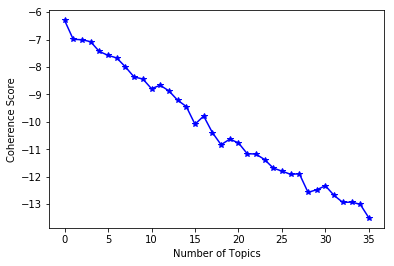

In [62]:
plt.plot(c_score,color='blue',marker='*')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
